In [214]:
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import calendar

pd.options.display.max_rows = 999

yf.pdr_override() # <== that's all it takes :-)

import PortfolioAnalyser as pa
import numpy as np
import statsmodels.api as sm

In [215]:
def compute_rolling_cagr(dataframe, years):
    rolling_result = []
    number = len(dataframe)

    for i in np.arange(1, number + 1):
        df = dataframe.iloc[:i]
        df = filter_by_years(df, years=years)
        result = (((df.iloc[-1] / df.iloc[0]) ** (1/years) - 1))
        rolling_result.append(result[0])

    final_df = pd.DataFrame(data = rolling_result, index = dataframe.index[0:number], columns = ['Ret'])
    final_df = final_df.loc[dataframe.index[0] + pd.DateOffset(years=years):]
    return final_df  

def filter_by_years(dataframe, years=0):
    
    last_date = dataframe.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
    
    if month_nr == 2 and day_nr == 29 and years % 4 != 0:
        new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr-1)        
    else:
        new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    df = dataframe.loc[new_date:]
    
    dataframe = pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])
    # Delete repeated days
    dataframe = dataframe.loc[~dataframe.index.duplicated(keep='first')]

    return dataframe

# Multi_period_return (in CAGR)
def multi_period_return(df, years = 1, days=252):
    shifted = df.shift(days * years)
    One_year = (((1 + (df - shifted) / shifted) ** (1 / years))-1)  * 100
    return One_year

def compute_r2(x, y, k=1):
    xpoly = np.column_stack([x**i for i in range(k+1)])    
    return sm.OLS(y, xpoly).fit().rsquared

def compute_r2_table(df, benchmark):

# df of prices

    lista = []

    for i in np.arange(0, len(df.columns)):
        lista.append(compute_r2(benchmark, df.iloc[: , i]))
             
    Dataframe = pd.DataFrame(lista)
    
    Dataframe.index = df.columns
    
    Dataframe.columns = [benchmark.name]
    
    return(round(Dataframe.transpose(), 3))

In [216]:
hy_yield = pdr.get_data_fred('BAMLH0A0HYM2EY', start='2004-12-16')

hy_yield.columns = ['HY yield']

hy_yield = hy_yield * 0.75

In [217]:
# download dataframe using pandas_datareader
HYG = pdr.get_data_yahoo("HYG", start="2004-12-16", end="2020-12-30")[['Adj Close']]

HYG.columns = ['HYG']

days = int(252 * 5.1)

dates_index = pd.DataFrame(pd.bdate_range(start='2004-12-16', end="2026-01-01"))

hy_yield = pd.concat([dates_index, hy_yield.set_index(dates_index.index[:len(hy_yield)])], axis=1)
hy_yield = hy_yield.set_index(0)

hy_yield = hy_yield.shift(periods=days)

HYG_rr = pa.compute_rolling_cagr(HYG, years=5) * 100

data = pa.merge_time_series(HYG_rr, hy_yield, how='outer')
data.columns = ['HYG', 'HY yield']

[*********************100%***********************]  1 of 1 completed


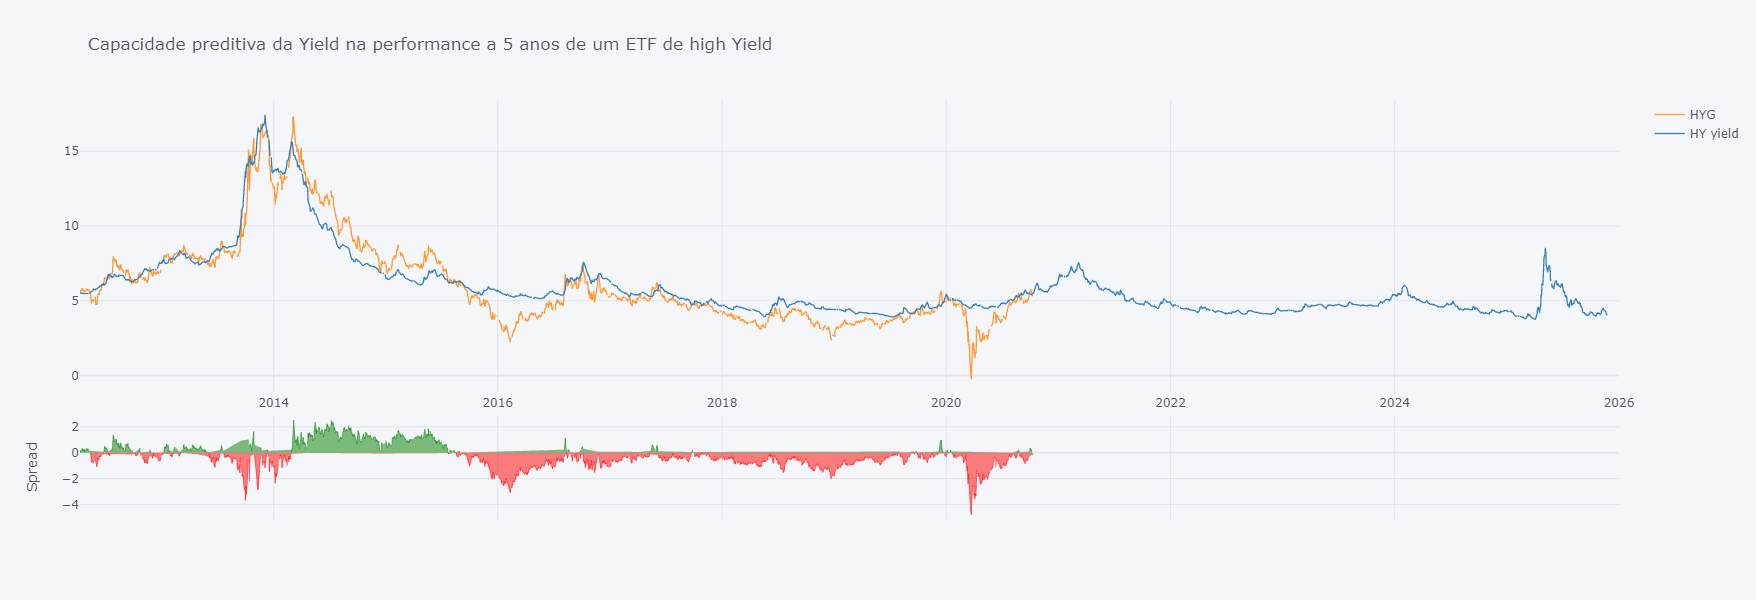

In [219]:
data.loc['2012-04-10':].iplot(dimensions=(950, 600), kind='spread',
                              title='Capacidade preditiva da Yield na performance a 5 anos de um ETF de high Yield')

**Scatterplot HY yield vs HYG 5 year returns**

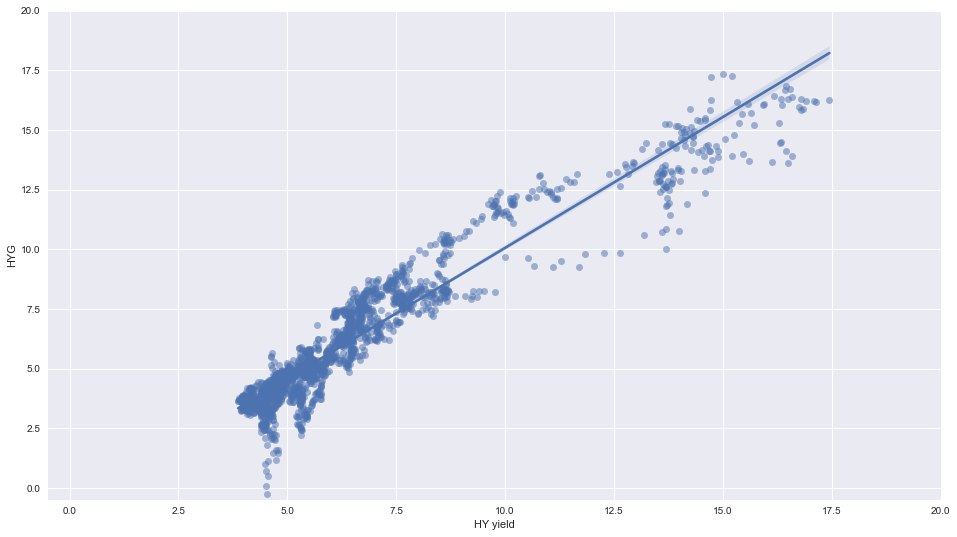

In [205]:
plt.figure(figsize=(16,9))
plt.ylim(-0.5, 20)
plt.xlim(-0.5, 20)

pa.print_title('Scatterplot HY yield vs HYG 5 year returns')
sns.regplot(data=data, x='HY yield', y='HYG', fit_reg=True, scatter_kws={'alpha':0.5});

In [206]:
data_nona = data.dropna()

In [207]:
import statsmodels.api as sm

X = data_nona['HY yield']
Y = data_nona['HYG']

X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    HYG   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                 2.069e+04
Date:                Sun, 11 Oct 2020   Prob (F-statistic):               0.00
Time:                        15:14:15   Log-Likelihood:                -2800.6
No. Observations:                2114   AIC:                             5605.
Df Residuals:                    2112   BIC:                             5617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9061      0.053    -17.048      0.0

In [208]:
compute_r2_table(data_nona[['HYG']], data_nona['HY yield'])

,HYG
HY yield,0.91


In [209]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(data_nona, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=58.1208 , p=0.0000  , df_denom=2110, df_num=1
ssr based chi2 test:   chi2=58.2034 , p=0.0000  , df=1
likelihood ratio test: chi2=57.4162 , p=0.0000  , df=1
parameter F test:         F=58.1208 , p=0.0000  , df_denom=2110, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=32.4250 , p=0.0000  , df_denom=2107, df_num=2
ssr based chi2 test:   chi2=65.0040 , p=0.0000  , df=2
likelihood ratio test: chi2=64.0237 , p=0.0000  , df=2
parameter F test:         F=32.4250 , p=0.0000  , df_denom=2107, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=26.7413 , p=0.0000  , df_denom=2104, df_num=3
ssr based chi2 test:   chi2=80.4907 , p=0.0000  , df=3
likelihood ratio test: chi2=78.9941 , p=0.0000  , df=3
parameter F test:         F=26.7413 , p=0.0000  , df_denom=2104, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=21.4194 , p=0.

{1: ({'ssr_ftest': (58.12078651210308, 3.701523448135788e-14, 2110.0, 1),
   'ssr_chi2test': (58.20342270145678, 2.3636747015823338e-14, 1),
   'lrtest': (57.416227556356716, 3.526853874720425e-14, 1),
   'params_ftest': (58.120786512104495, 3.701523448133026e-14, 2110.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (32.42503872963192, 1.3500474209833826e-14, 2107.0, 2),
   'ssr_chi2test': (65.0039694323518, 7.665974792519506e-15, 2),
   'lrtest': (64.02367436563964, 1.2515141260194461e-14, 2),
   'params_ftest': (32.425038729633656, 1.3500474209814353e-14, 2107.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (26.74125927809308, 5.688056292144134e-17, 2104.0, 3),
   'ssr_chi2test': (80.4906820381005, 2.4086949064865093e-17, 3),
   'lrtest': (78.9940847083999, 5.0441364791009515e-17, 3),
   'params_ftest': (26.741259278086943, 5.68805629219316e-17, 2104.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 

[*********************100%***********************]  1 of 1 completed


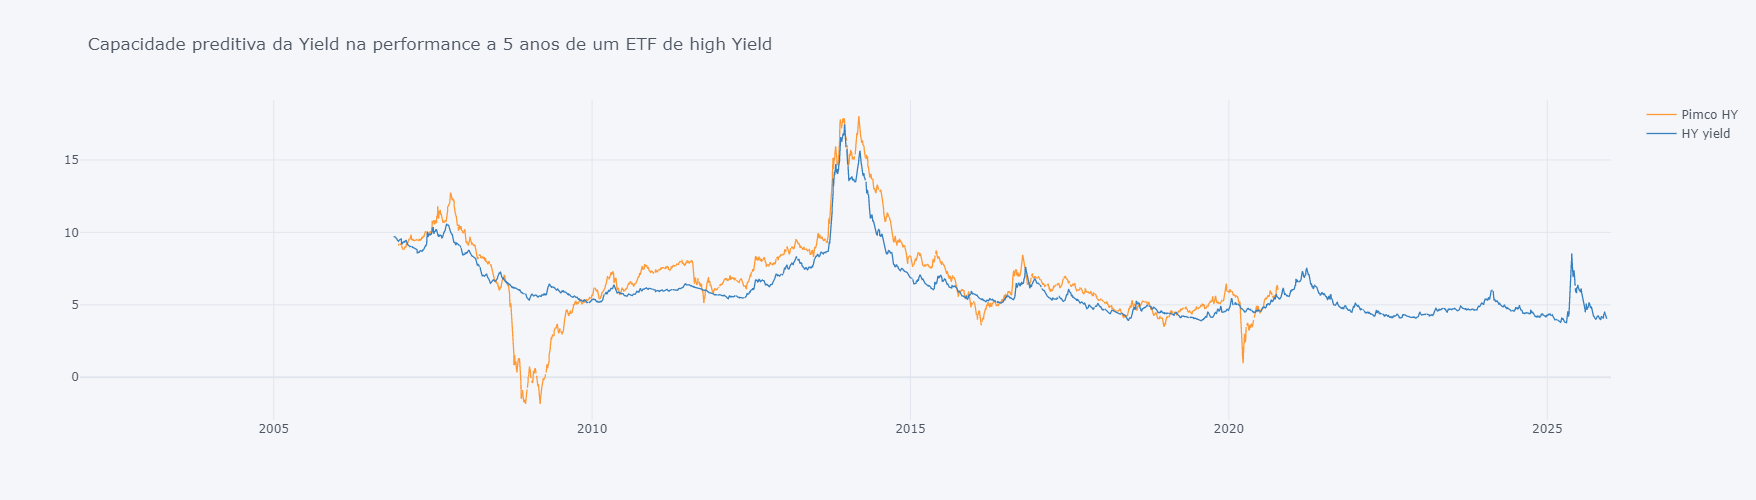

In [210]:
hy_yield = pdr.get_data_fred('BAMLH0A0HYM2EY', start='2001-12-16')

hy_yield.columns = ['HY yield']

hy_yield = hy_yield * 0.75

# download dataframe using pandas_datareader
HYG = pdr.get_data_yahoo("PHIYX", start="2001-12-16", end="2020-12-30")[['Adj Close']]

HYG.columns = ['Pimco HY']

days = int(252 * 5.1)

dates_index = pd.DataFrame(pd.bdate_range(start='2001-12-16', end="2026-01-01"))

hy_yield = pd.concat([dates_index, hy_yield.set_index(dates_index.index[:len(hy_yield)])], axis=1)
hy_yield = hy_yield.set_index(0)

hy_yield = hy_yield.shift(periods=days)

HYG_rr = multi_period_return(HYG, years=5, days=252)

data = pa.merge_time_series(HYG_rr, hy_yield, how='outer')

data.iplot(dimensions=pa.dimensions, title ='Capacidade preditiva da Yield na performance a 5 anos de um ETF de high Yield')

# Comparação com Pimco High Yield americano por causa do histórico mais longo

In [211]:
data_2 = data.dropna()
compute_r2_table(data_2[['Pimco HY']], data_2['HY yield'])

,Pimco HY
HY yield,0.75


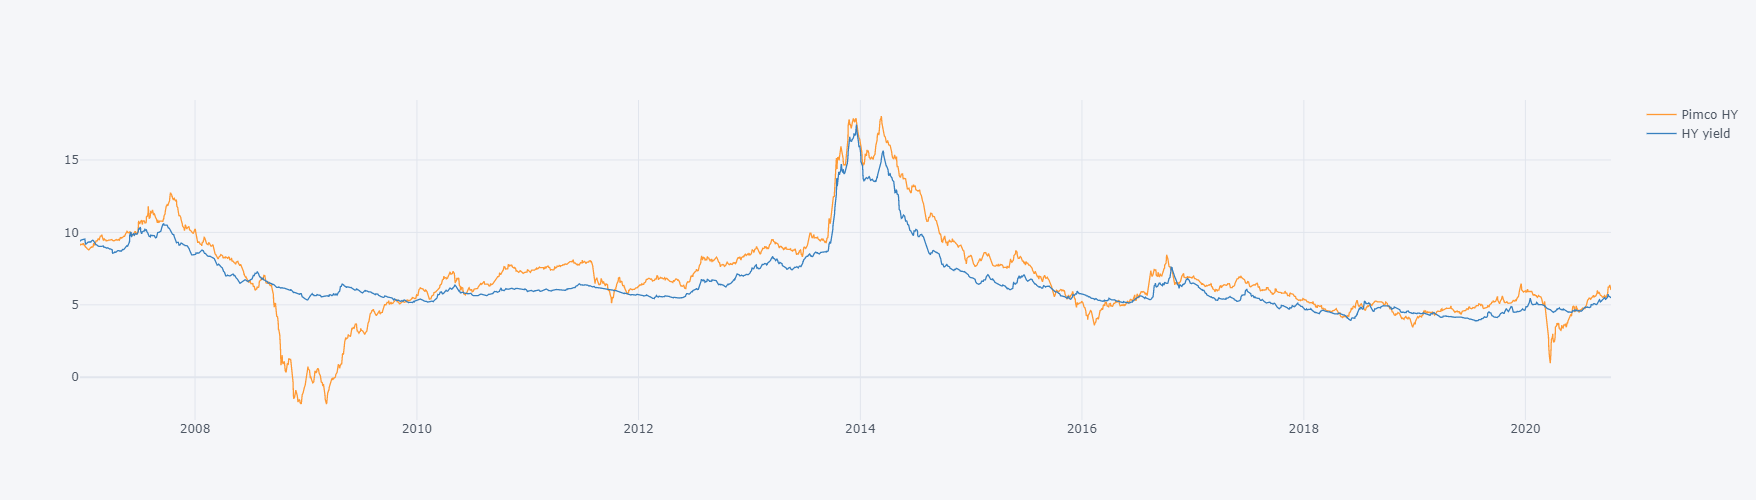

In [212]:
data_2.iplot(dimensions=pa.dimensions)